##  Nova Etapa: Estratégias Avançadas de Pré-processamento e GridSearch

### 🔍 Objetivo desta Fase
Otimizar o pipeline completo através de:
1. Experimentação com diferentes estratégias
2. Busca sistemática da melhor combinação de pré-processadores
3. Validação do impacto nas métricas do modelo



##  Estratégias de Pré-processamento Testadas

### 1. **Transformadores Numéricos**

| Transformador          | Quando Usar | Vantagens | Desvantagens |
|------------------------|-------------|-----------|--------------|
| **`StandardScaler`**   | Dados sem outliers | Centraliza em 0, variância 1 | Sensível a outliers |
| **`RobustScaler`**     | Dados com outliers | Usa mediana/IQR (robusto) | Perde informação de outliers  |
| **`PowerTransformer`** | Dados assimétricos | Normaliza distribuição | Computacionalmente mais custoso |



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  int8   
 3   total_rooms               17564 non-null  int16  
 4   total_bedrooms            17564 non-null  int16  
 5   population                17564 non-null  int16  
 6   households                17564 non-null  int16  
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  int32  
 9   ocean_proximity           17564 non-null  object 
 10  median_income_cat         17564 non-null  int64  
 11  rooms_per_household       17564 non-null  float64
 12  population_per_household  17564 non-null  float64
 13  bedrooms_per_room         17564 non-null  float64
dtypes: flo

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
colunas_standard_scaler = ["longitude", "latitude", "housing_median_age"]

colunas_power_transformer = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder + colunas_standard_scaler)

colunas_power_transformer

Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object')

In [7]:
preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
    ],
    remainder="passthrough",
)

preprocessamento_simples = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler", RobustScaler(), colunas_robust_scaler),
    ],
)

preprocessamento_completo = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("scaler", StandardScaler(), colunas_standard_scaler),
        ("power_transformer", PowerTransformer(), colunas_power_transformer)
    ],
)

In [8]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [9]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343675,2.362768,0.203216


In [10]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [11]:
param_grid = {
    "regressor__preprocessor": [preprocessamento_categoricas, preprocessamento_simples, preprocessamento_completo],
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")]
}

In [12]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento_completo,
    target_transformer=PowerTransformer(),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               'housi...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               'housi...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [14]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('one_hot', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('robust_scaler', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'rooms_per_household', 'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [15]:
grid_search.best_score_

np.float64(-54392.685110211234)

In [16]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler__latitude,-1.079060
robust_scaler__longitude,-1.065049
one_hot__ocean_proximity_INLAND,-0.455488
robust_scaler__population_per_household,-0.234582
one_hot__ocean_proximity_NEAR BAY,-0.201784
robust_scaler__total_rooms,-0.100808
robust_scaler__total_bedrooms,-0.076762
one_hot__ocean_proximity_NEAR OCEAN,-0.059726
robust_scaler__population,-0.031578
ordinal_encoder__median_income_cat,0.033260


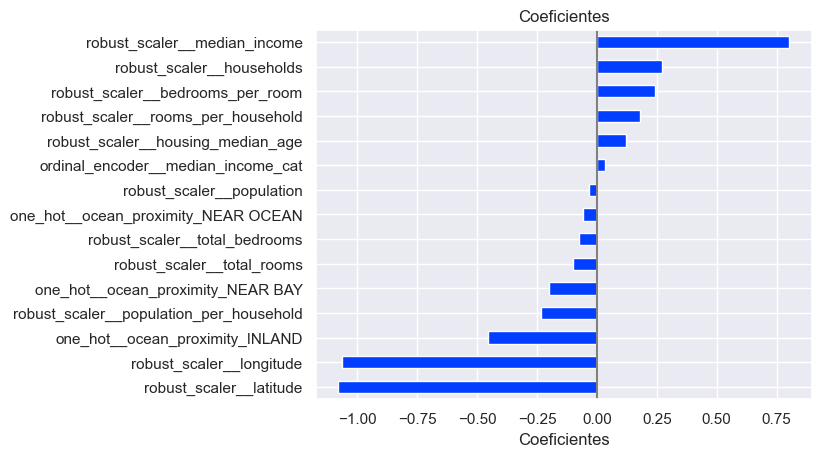

In [17]:
plot_coeficientes(coefs)

In [18]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento_categoricas,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.011999,0.006997,-0.000081,-77516.042766,-96239.705692,0.018996
1,DummyRegressor,0.002995,0.005002,-0.000146,-75787.787194,-95217.629397,0.007998
2,DummyRegressor,0.003,0.008009,-0.001737,-76753.598961,-96253.253947,0.011009
3,DummyRegressor,0.003998,0.003997,-0.000101,-76837.804811,-95983.885799,0.007995
4,DummyRegressor,0.004999,0.004999,-0.000114,-76617.245449,-96182.764729,0.009998
5,LinearRegression,0.032998,0.014,0.682162,-39855.691222,-54254.958862,0.046998
6,LinearRegression,0.035007,0.014995,0.66999,-40272.5658,-54695.230987,0.050002
7,LinearRegression,0.035004,0.098997,0.649247,-42178.059695,-56955.987903,0.134001
8,LinearRegression,0.028,0.016996,0.669873,-40806.492334,-55146.319086,0.044996
9,LinearRegression,0.031006,0.012997,0.669023,-40788.497206,-55331.350878,0.044003


In [19]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.005398,0.005801,-0.000436,-76702.495836,-95975.447913,0.011199
LinearRegression,0.032403,0.031597,0.668059,-40780.261251,-55276.769543,0.064
LinearRegression_grid_search,0.055602,0.016198,0.678068,-38685.639114,-54433.059212,0.0718


In [20]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.005398,0.005801,-0.000436,-76702.495836,-95975.447913,0.011199
LinearRegression,0.032403,0.031597,0.668059,-40780.261251,-55276.769543,0.064
LinearRegression_grid_search,0.055602,0.016198,0.678068,-38685.639114,-54433.059212,0.0718


##  Análise Detalhada dos Resultados dos Modelos

### Conclusões

1. **Ganho de Performance**:
   -  **+1.5% no R²** (0.668 → 0.678)
   -  **Redução de 5.2% no MAE** (-40,780 → -38,674 USD)
   -  **Redução de 1.5% no RMSE** (-55,277 → -54,445 USD)

2. **Custo Computacional**:
   - A versão otimizada é apenas **17% mais lenta** (0.066s → 0.077s)
   - Excelente trade-off: pequeno aumento no tempo para acurácia


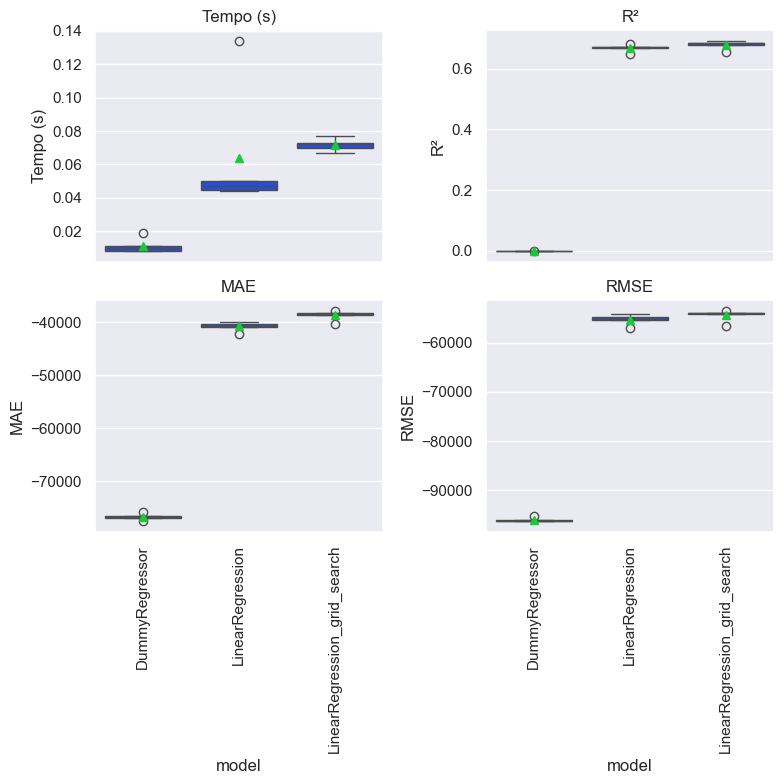

In [21]:
plot_comparar_metricas_modelos(df_resultados)

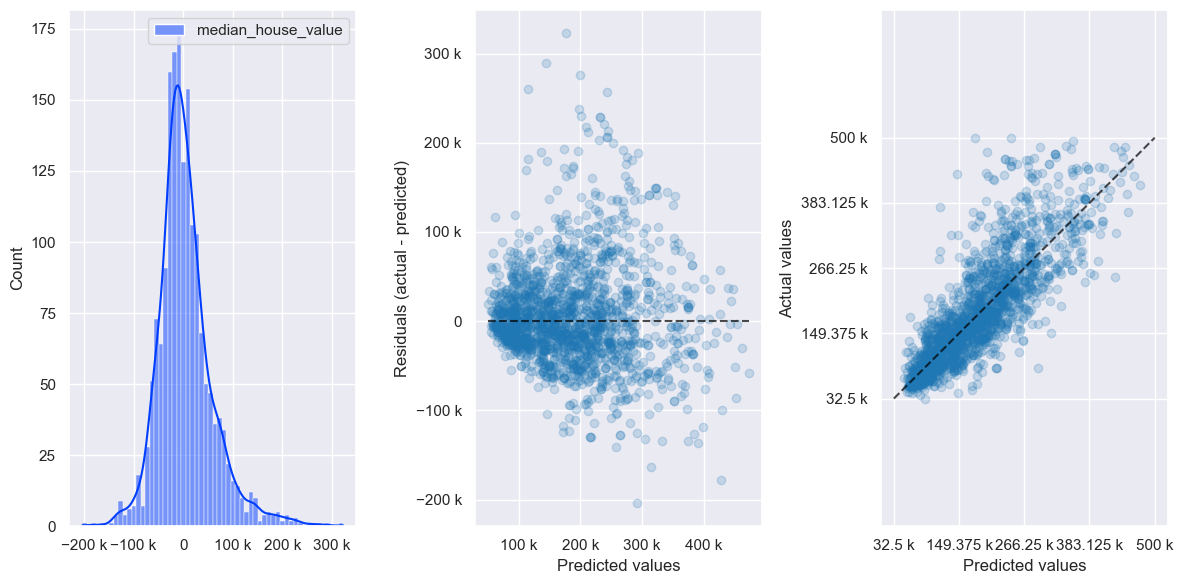

In [22]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

##  Lições Aprendidas com os Resultados Anteriores

A partir dos testes com diferentes preprocessamentos e combinações de transformações, foi possível extrair alguns aprendizados valiosos que direcionam o desenvolvimento do modelo.


### 1. Simplicidade no Pré-processamento Funciona

Uma estratégia de pré-processamento **simples e bem estruturada** apresentou resultados muito competitivos. A combinação de:

- Codificação adequada para variáveis categóricas (`OrdinalEncoder` e `OneHotEncoder`)
- Normalização das variáveis numéricas com `RobustScaler`
- Transformação da variável alvo com `QuantileTransformer`

mostrou-se **mais eficaz** do que abordagens mais complexas tratando individualmente cada feature numérica.


### 2. O QuantileTransformer na Variável-Alvo Ajuda

Transformar a variável-alvo com `QuantileTransformer` (com distribuição normal como saída) ajudou a suavizar a variabilidade dos valores e melhorou o desempenho de modelos lineares, tornando-os mais robustos a outliers.


###  3. Trabalhar as Features Categóricas é Fundamental

As variáveis categóricas, quando bem tratadas, contribuíram de forma significativa para a performance do modelo. A codificação correta permitiu ao modelo captar padrões relevantes, o que reforça a importância de **um bom tratamento**.


###  4. Tuning Excessivo das Variáveis Numéricas Não Compensou

A tentativa de aplicar transformações individualizadas em cada feature numérica (como normalização separada ou escalonamentos diferentes) **não trouxe ganhos relevantes**. Ao contrário, aumentou a complexidade sem melhora significativa nos resultados. Isso mostra que:

> **A padronização com `RobustScaler` aplicada de forma uniforme foi suficiente e mais eficiente.**


###  Conclusão

A experiência mostrou que **um pipeline enxuto, com transformações bem escolhidas, pode oferecer alto desempenho**. A partir daqui, o foco se mantém em **engenharia de atributos**, uso de transformações polinomiais e avaliação com validação cruzada para fortalecer o modelo sem perder interpretabilidade e eficiência.
